In [ ]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os
import matplotlib.pyplot as plt
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

In [ ]:
import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)


def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)


def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = W.device
    # device = torch.device('cpu')
    (m, n) = W.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        # Hr = RHT_H(Hr, SU)
        Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

In [ ]:
model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-13b-hf',
]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)[:2]

    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():

            fig = plt.figure(figsize=(6, 3))

            W_ori = m.weight.data.detach()
            W = W_ori/W_ori.std()
            
            rounded_W = torch.round(W.flatten() * 1000 * W_ori.std()) / 1000 / W_ori.std()
            unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            sorted_indices = torch.argsort(unique_vals)
            sorted_vals = unique_vals[sorted_indices]
            sorted_counts = counts[sorted_indices]
            ax = fig.add_subplot(111)
            ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label='W (normalized)')

            # Lhr, H, Wr, SU, SV, scaleWH = incoherence_preprocess(None, W, None)
            # rounded_W = torch.round(Wr.flatten() * 1000) / 1000
            # unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            # sorted_indices = torch.argsort(unique_vals)
            # sorted_vals = unique_vals[sorted_indices]
            # sorted_counts = counts[sorted_indices]
            # ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label='RHT W')
            
            # W /= W.std(dim=0, keepdim=True)
            W = W_ori/W_ori.std(dim=1, keepdim=True)
            rounded_W = torch.round(W.flatten() * 1000 * W_ori.std()) / 1000 / W_ori.std()
            unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            sorted_indices = torch.argsort(unique_vals)
            sorted_vals = unique_vals[sorted_indices]
            sorted_counts = counts[sorted_indices]
            ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label='W (rowwise normalized)')
            
            W = W_ori/W_ori.std(dim=0, keepdim=True)
            rounded_W = torch.round(W.flatten() * 1000 * W_ori.std()) / 1000 / W_ori.std()
            unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            sorted_indices = torch.argsort(unique_vals)
            sorted_vals = unique_vals[sorted_indices]
            sorted_counts = counts[sorted_indices]
            ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label='W (colwise normalized)')
            
            # ax.set_xlim(-0.1, 0.1)
            plt.legend()
            filename = f"./weight_dist_plot/{model_name}/{i}_{n}.png"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            plt.suptitle(f'{i}_{n}')
            plt.show()      
            # plt.savefig(filename)
            # plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기


model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00, 130.41it/s]


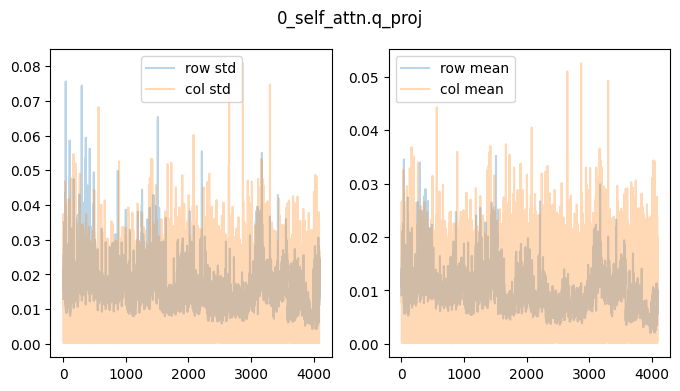

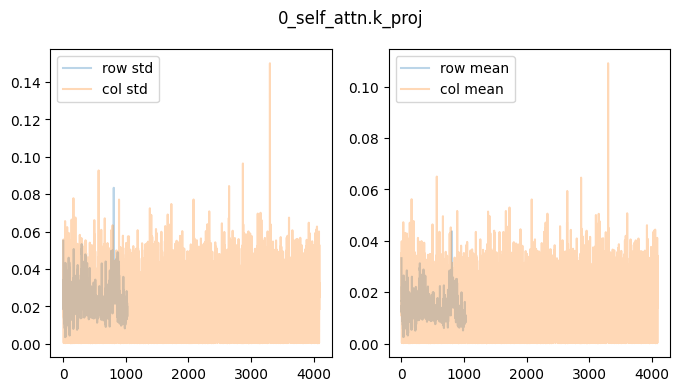

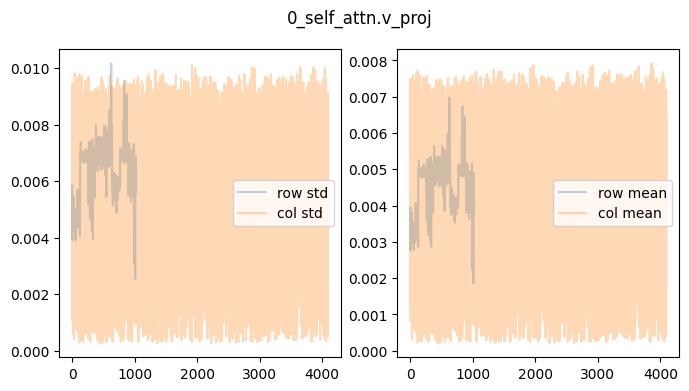

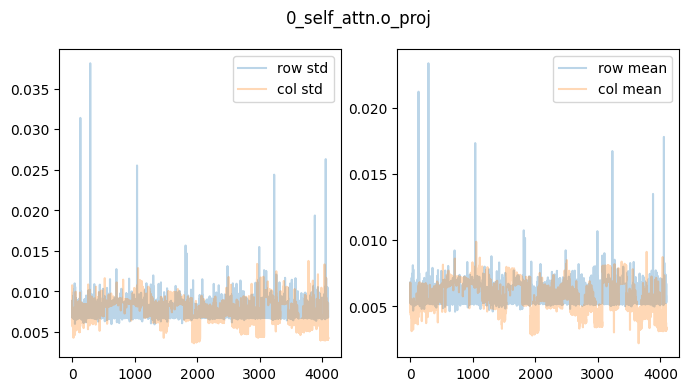

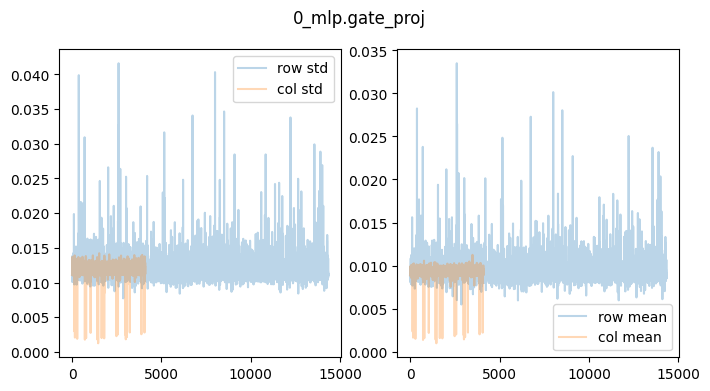

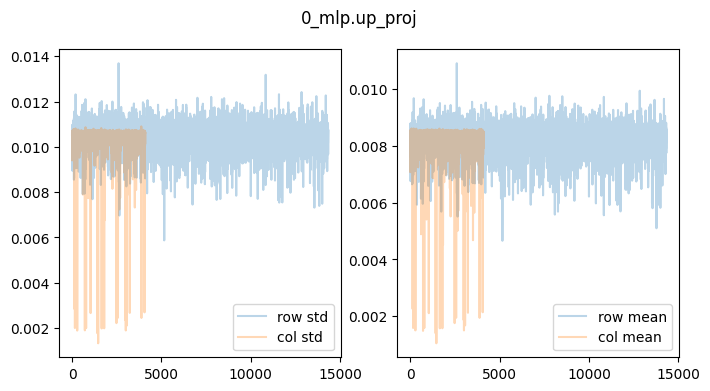

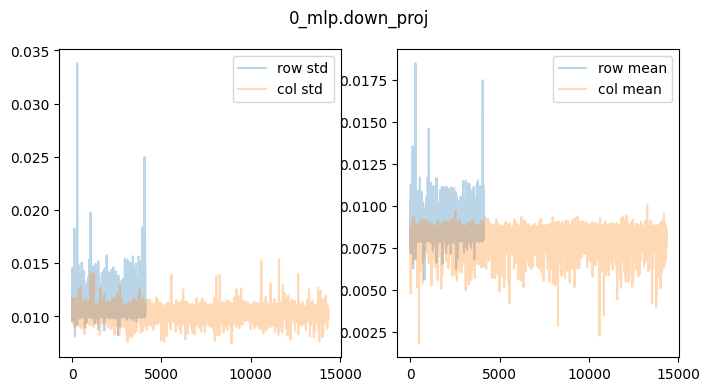

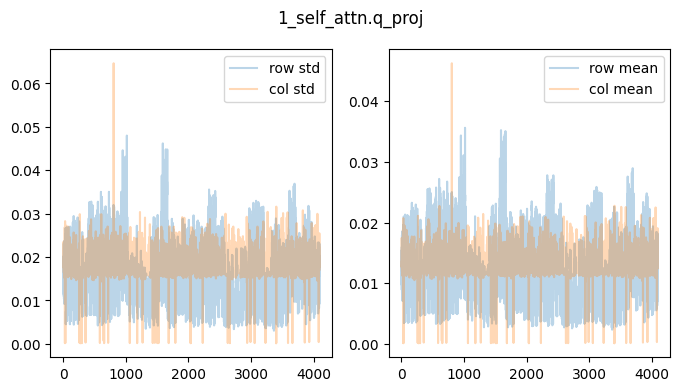

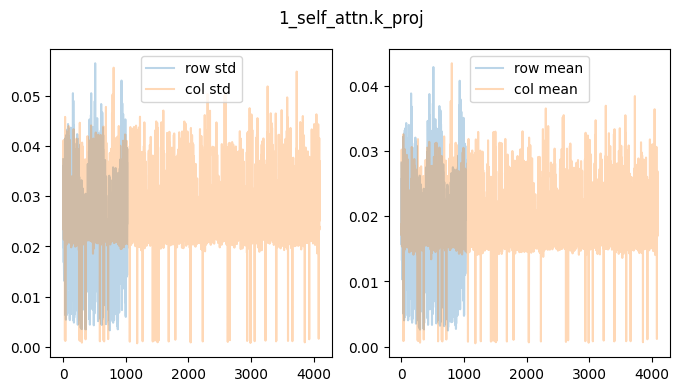

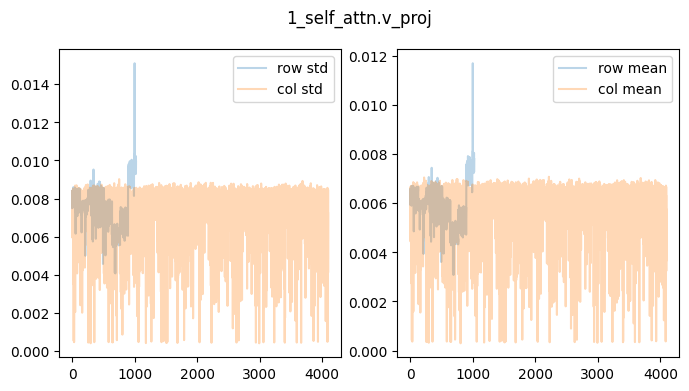

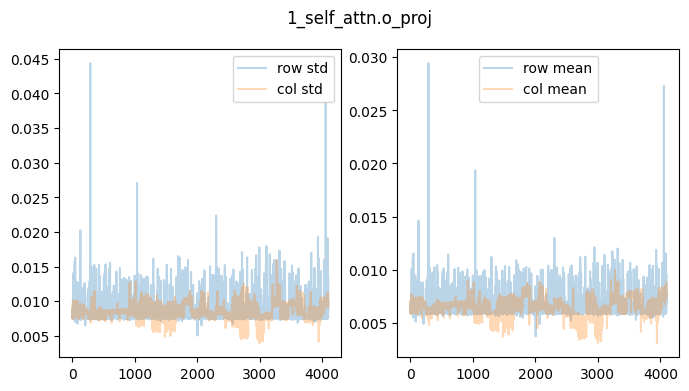

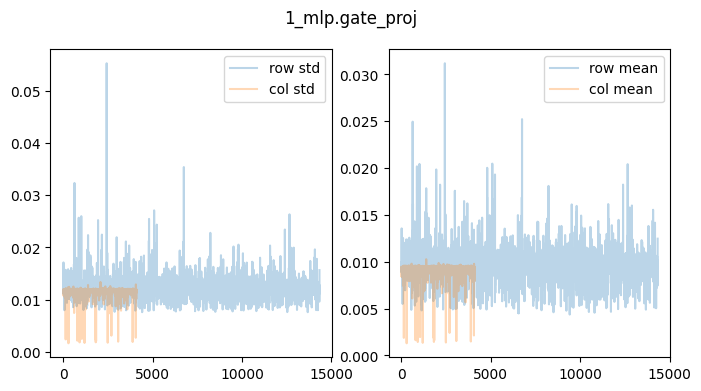

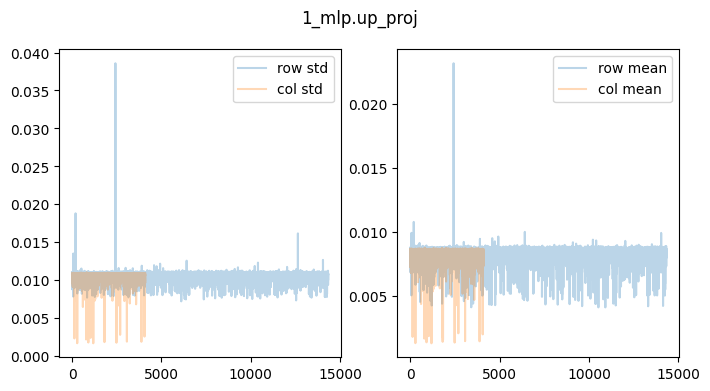

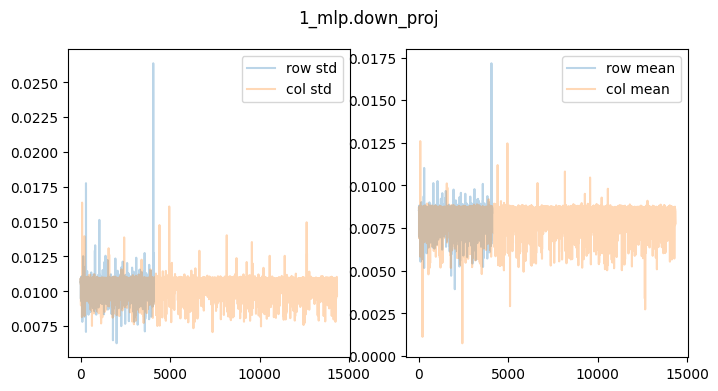

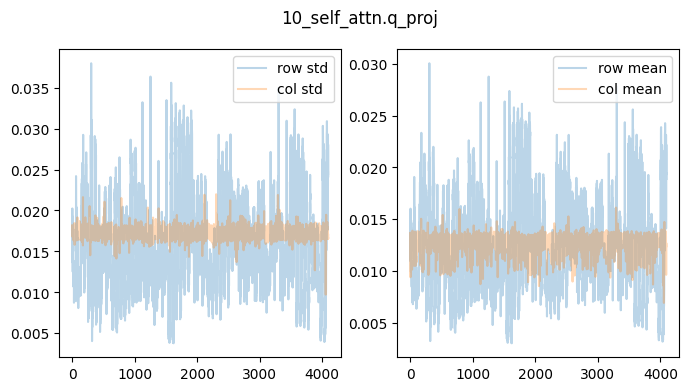

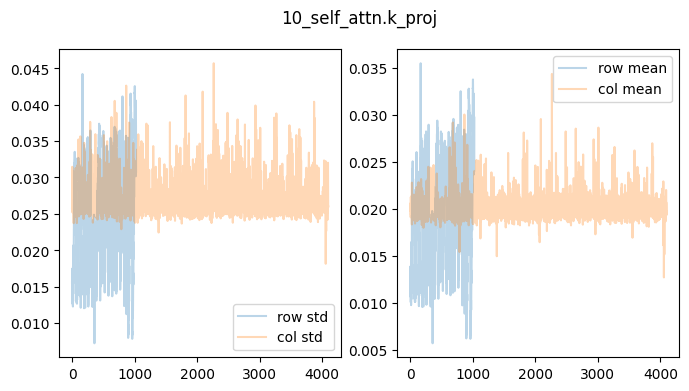

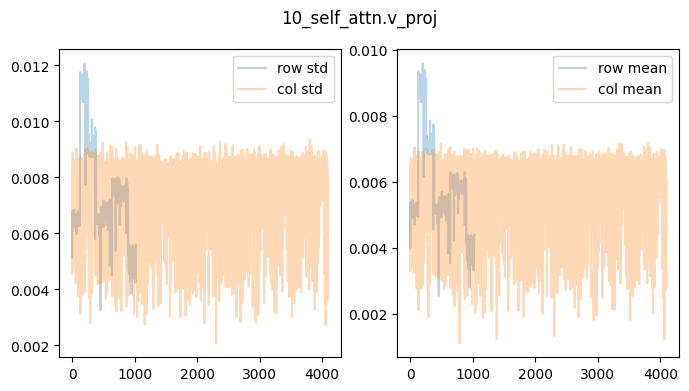

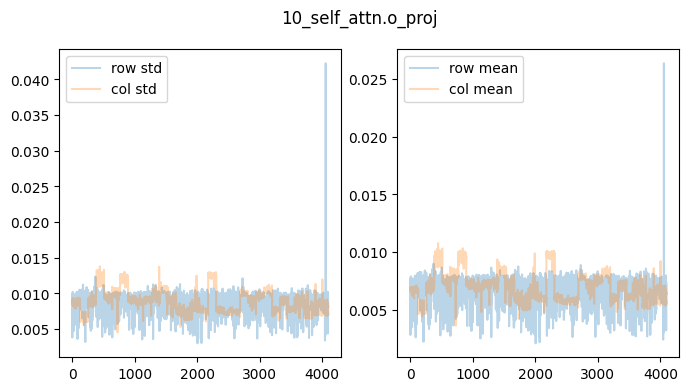

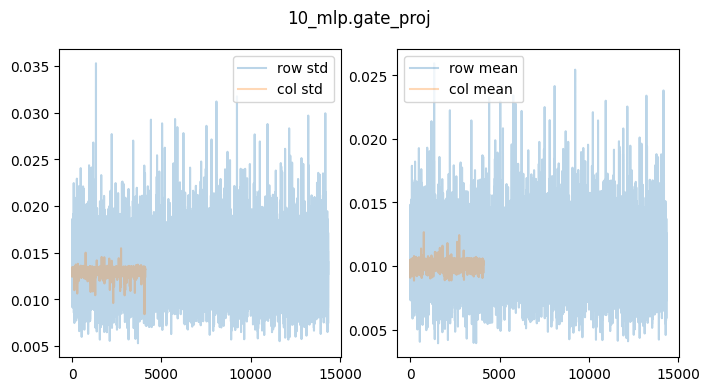

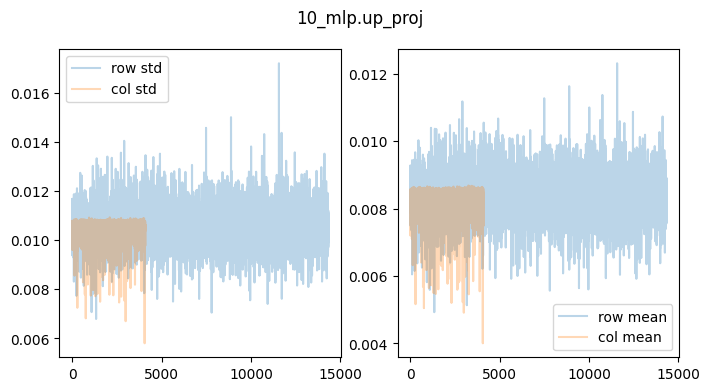

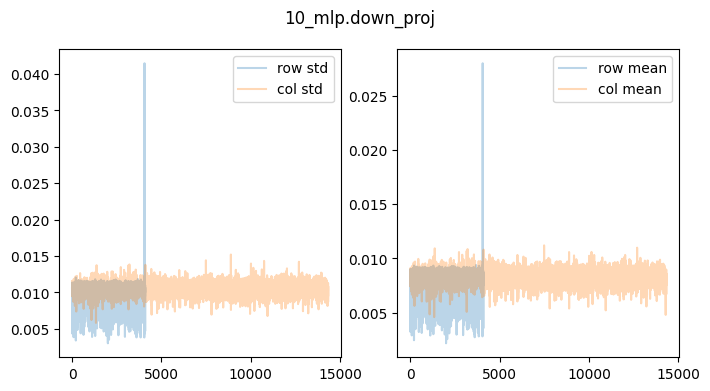

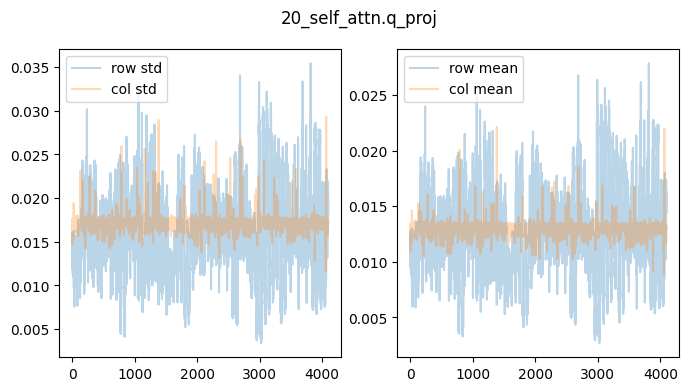

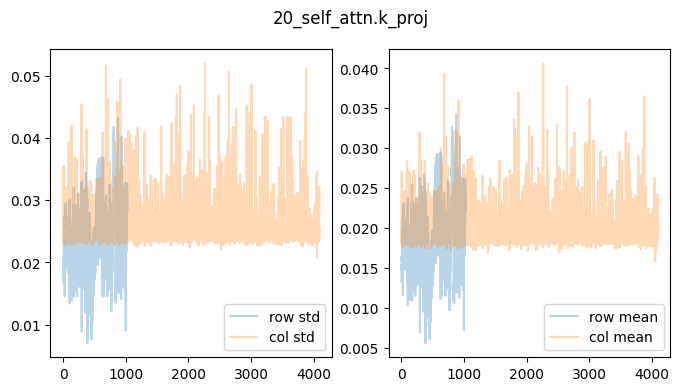

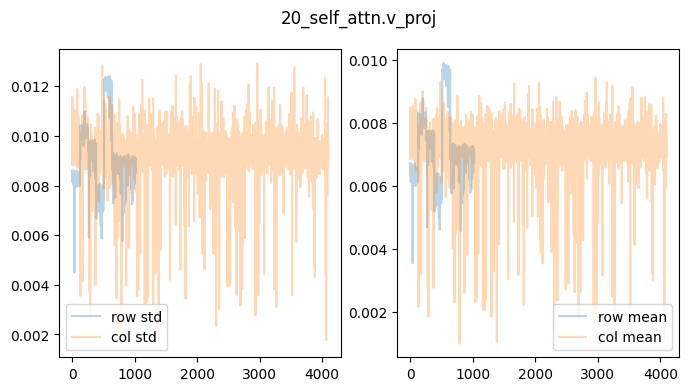

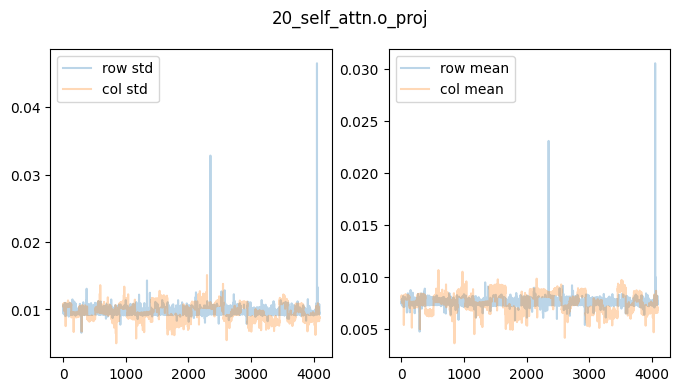

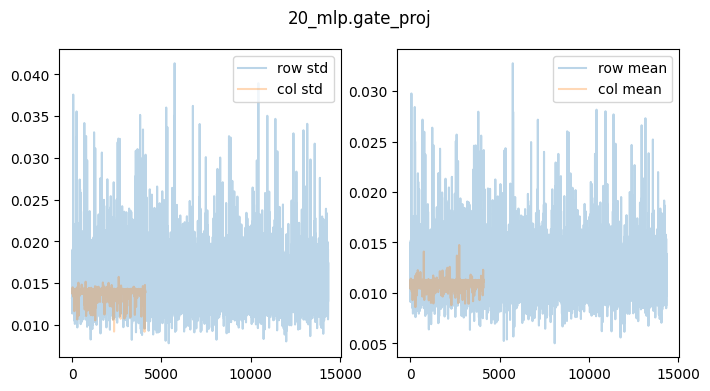

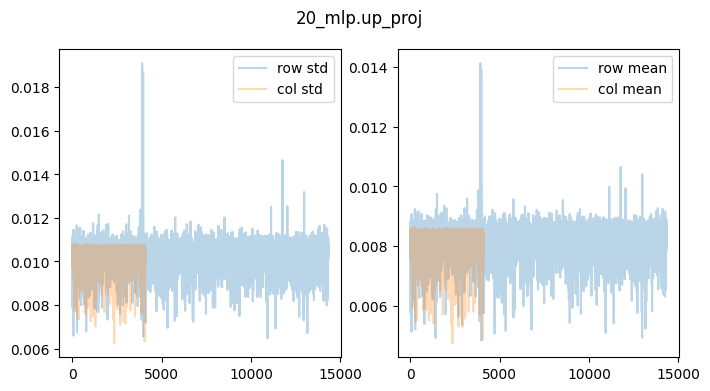

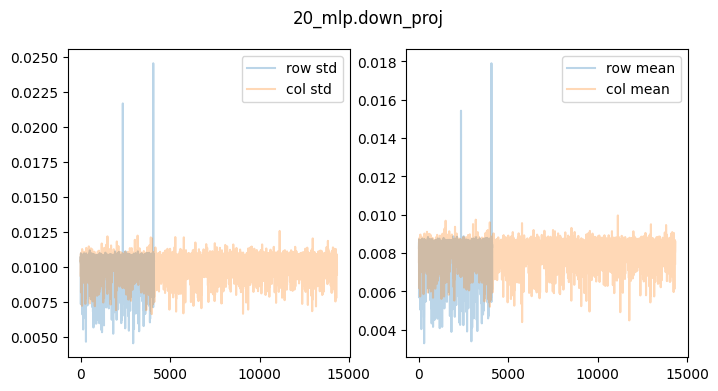

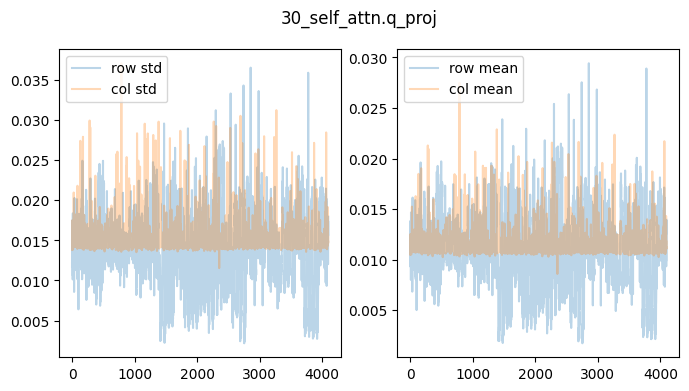

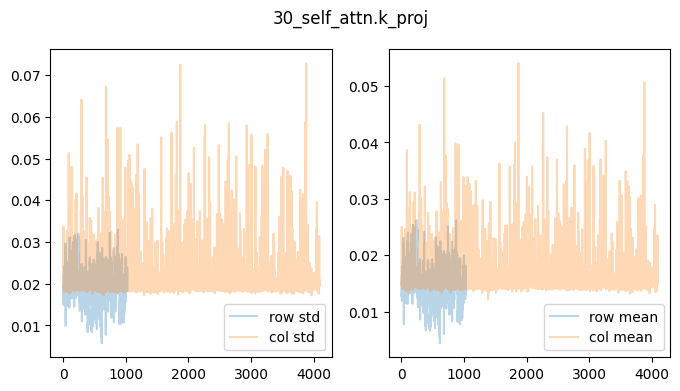

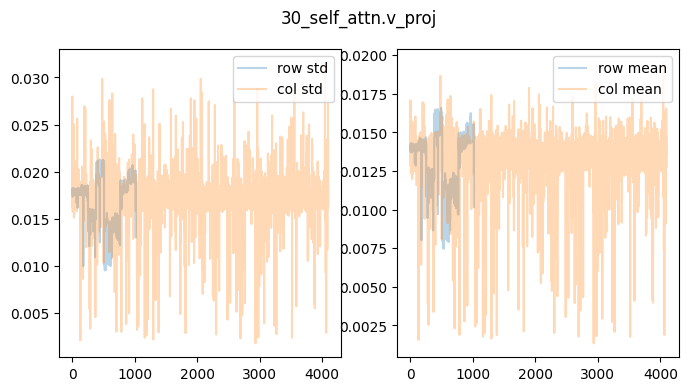

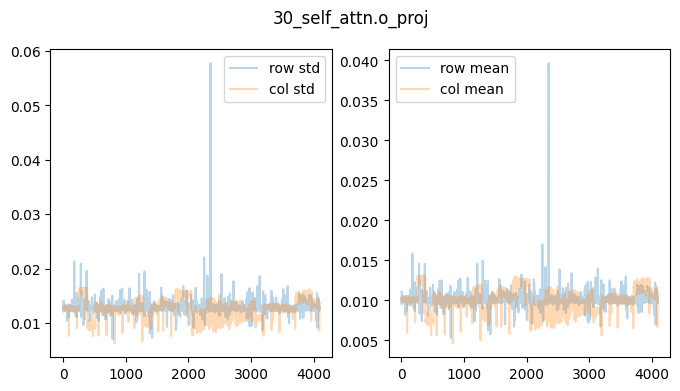

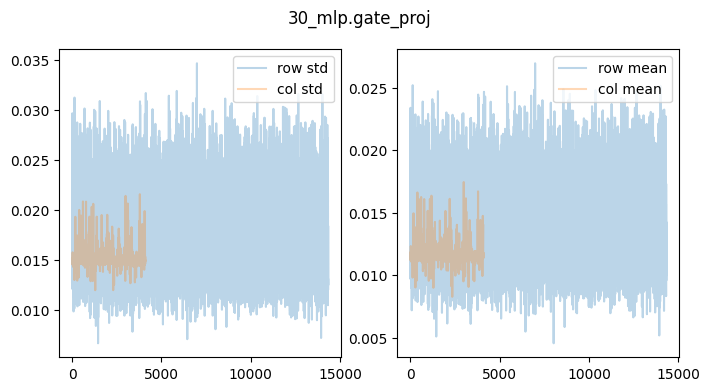

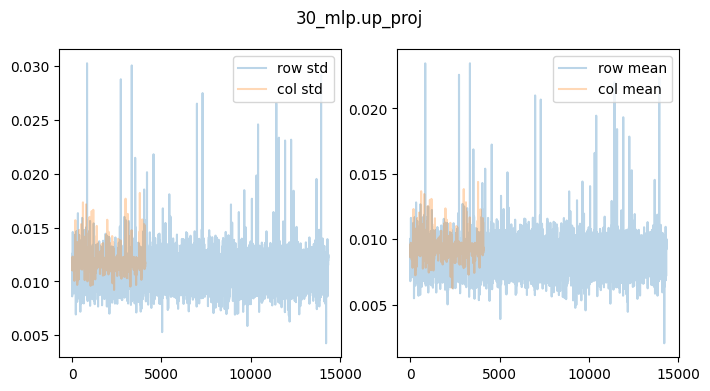

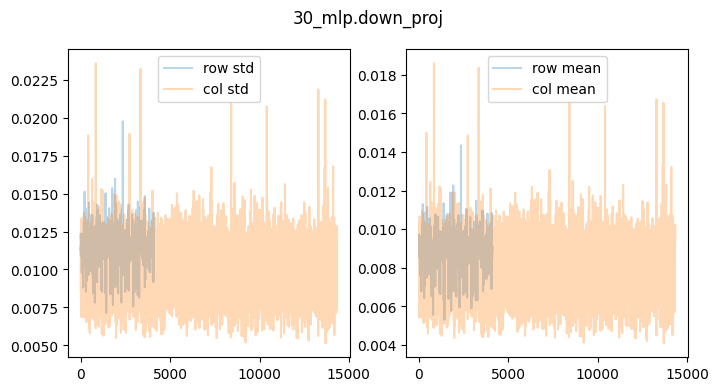

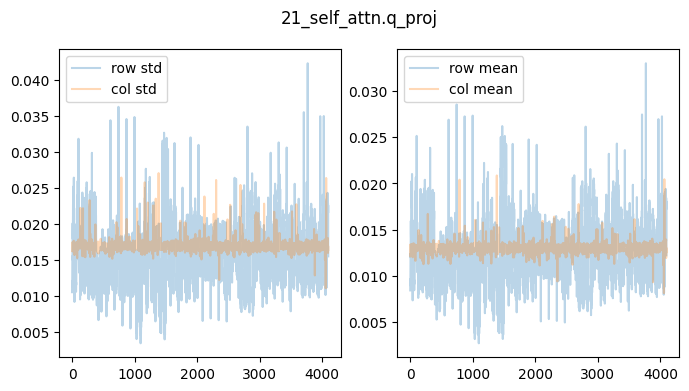

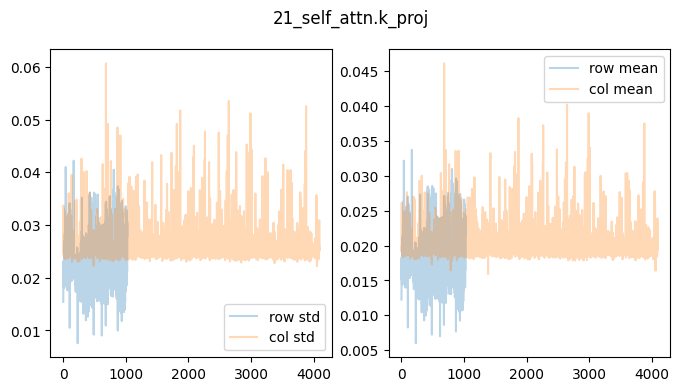

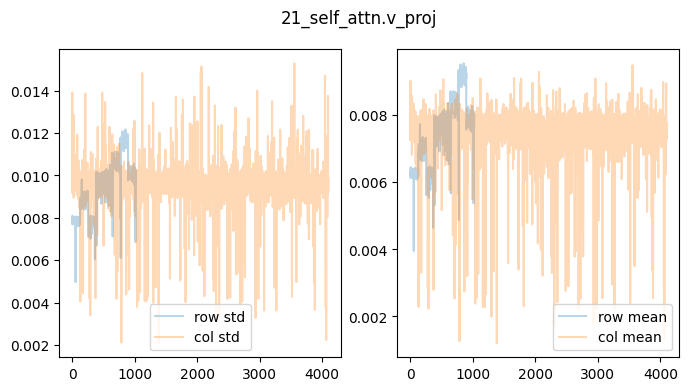

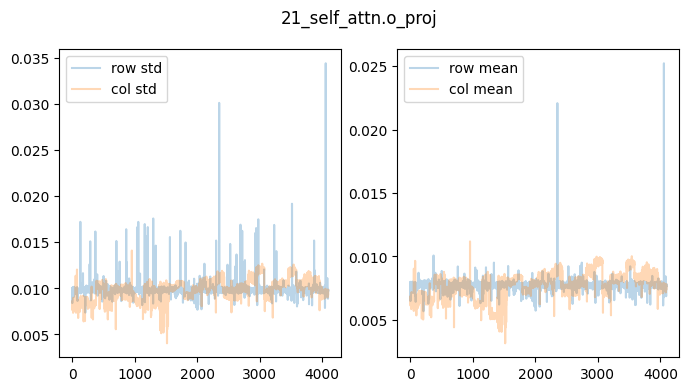

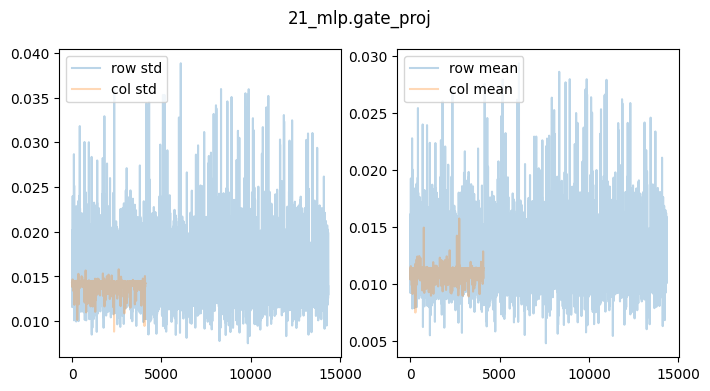

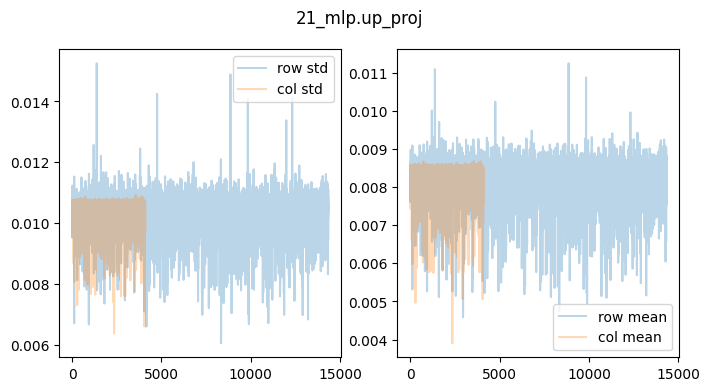

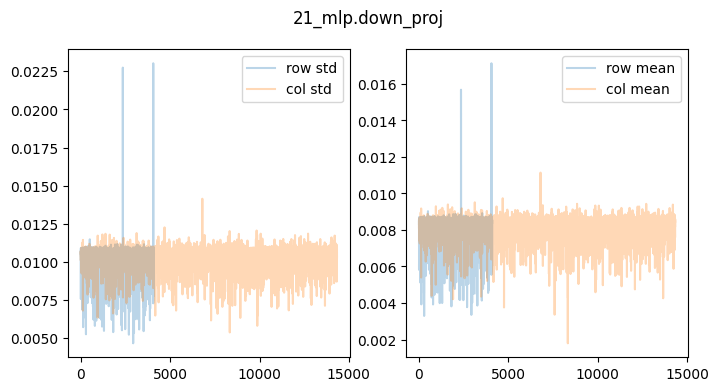

In [14]:
model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-13b-hf',
]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    # for i in tqdm(range(len(layers))):
    for i in [0, 1, 10, 20, 30, 21]:
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():

            fig = plt.figure(figsize=(8, 4))

            W_ori = m.weight.data.detach()
            
            row = W_ori.std(dim=1)
            col = W_ori.std(dim=0)
            
            ax = fig.add_subplot(121)
            ax.plot(row, alpha = 0.3, label='row std')
            ax.plot(col, alpha = 0.3, label='col std')
            ax.legend()
            
            row = W_ori.abs().mean(dim=1)
            col = W_ori.abs().mean(dim=0)
            
            ax = fig.add_subplot(122)
            ax.plot(row, alpha = 0.3, label='row mean')
            ax.plot(col, alpha = 0.3, label='col mean')
            ax.legend()
            
            # W = W_ori/W_ori.std()
            # W = torch.round(W * 1000 * W_ori.std()) / 1000 / W_ori.std()
            # ax = fig.add_subplot(131)
            # ax.set_title('W (normalized)')
            
            # for r in W[:10]:
            #     rounded_W = r.flatten()
            #     unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            #     sorted_indices = torch.argsort(unique_vals)
            #     sorted_vals = unique_vals[sorted_indices]
            #     sorted_counts = counts[sorted_indices]
            #     ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=0.5)
            
            # W = W_ori/W_ori.std(dim=1, keepdim=True)
            # W = torch.round(W * 1000 * W_ori.std()) / 1000 / W_ori.std()
            # ax = fig.add_subplot(132)
            # ax.set_title('W (row normalized)')
            
            # for r in W[:10]:
            #     rounded_W = r.flatten()
            #     unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            #     sorted_indices = torch.argsort(unique_vals)
            #     sorted_vals = unique_vals[sorted_indices]
            #     sorted_counts = counts[sorted_indices]
            #     ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=0.5)
            
            # W = W_ori/W_ori.std(dim=0, keepdim=True)
            # W = torch.round(W * 1000 * W_ori.std()) / 1000 / W_ori.std()
            # W = W.T
            # ax = fig.add_subplot(133)
            # ax.set_title('W (col normalized)')
            # for r in W[:10]:
            #     rounded_W = r.flatten()
            #     unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            #     sorted_indices = torch.argsort(unique_vals)
            #     sorted_vals = unique_vals[sorted_indices]
            #     sorted_counts = counts[sorted_indices]
            #     ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=0.5)
            
            # ax.set_xlim(-0.1, 0.1)
            # plt.legend()
            filename = f"./weight_dist_plot/{model_name}/{i}_{n}.png"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            plt.suptitle(f'{i}_{n}')
            plt.show()      
            # plt.savefig(filename)
            # plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기


In [ ]:
# import os
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.stats as stats
# from tqdm import tqdm
# from transformers import AutoModelForCausalLM

# model_list = [
#     'meta-llama--Llama-2-7b-hf',
#     'meta-llama/Meta-Llama-3-8B',
#     'meta-llama--Llama-2-13b-hf',
# ]

# for model_name in model_list:
#     model_name = model_name.replace('/', '--')
#     print('Processing model:', model_name)
    
#     model_path = f"./hf_model/{model_name}"
#     model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
#     layers = get_blocks(model)

#     for i in tqdm(range(len(layers))):
#         named_linears = get_named_linears(layers[i])
#         for n, m in named_linears.items():

#             fig = plt.figure(figsize=(8, 4))
#             ax = fig.add_subplot(111)

#             # 원본 가중치 W 처리
#             W = m.weight.data.detach()
#             rounded_W = torch.round(W.flatten() * 1000) / 1000
#             unique_vals, counts = torch.unique(rounded_W, return_counts=True)
#             sorted_indices = torch.argsort(unique_vals)
#             sorted_vals = unique_vals[sorted_indices]
#             sorted_counts = counts[sorted_indices] / W.numel()

#             # 평균과 분산 계산
#             mean_W = W.mean().item()
#             std_W = W.std().item()

#             # 정규 분포 그리기 (W)
#             x_vals = np.linspace(sorted_vals.min(), sorted_vals.max(), 100)
#             normal_dist_W = stats.norm.pdf(x_vals, mean_W, std_W) * (sorted_vals[1] - sorted_vals[0]).item()
#             ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label='W', color='blue')
#             ax.plot(x_vals, normal_dist_W, '--', color='blue', alpha=0.6, label=f'N(W): μ={mean_W:.4f}, σ={std_W:.4f}')

#             # RHT 적용 후 가중치 Wr 처리
#             Lhr, H, Wr, SU, SV, scaleWH = incoherence_preprocess(None, W, None)
#             rounded_Wr = torch.round(Wr.flatten() * 1000) / 1000
#             unique_vals, counts = torch.unique(rounded_Wr, return_counts=True)
#             sorted_indices = torch.argsort(unique_vals)
#             sorted_vals_rht = unique_vals[sorted_indices]
#             sorted_counts_rht = counts[sorted_indices] / Wr.numel()

#             # 평균과 분산 계산 (Wr)
#             mean_Wr = Wr.mean().item()
#             std_Wr = Wr.std().item()

#             # 정규 분포 그리기 (Wr)
#             x_vals_rht = np.linspace(sorted_vals_rht.min(), sorted_vals_rht.max(), 100)
#             normal_dist_Wr = stats.norm.pdf(x_vals_rht, mean_Wr, std_Wr)* (sorted_vals[1] - sorted_vals[0]).item()
#             ax.plot(sorted_vals_rht.numpy(), sorted_counts_rht.numpy(), alpha=1, label='RHT W', color='red')
#             ax.plot(x_vals_rht, normal_dist_Wr, '--', color='red', alpha=0.6, label=f'N(RHT W): μ={mean_Wr:.4f}, σ={std_Wr:.4f}')

#             # 범위 설정 및 그래프 저장
#             ax.set_xlim(-0.1, 0.1)
#             ax.legend()
#             plt.suptitle(f'Layer {i}, {n}')    

#             filename = f"./plot/weight_dist_plot_with_normal/{model_name}/{i}_{n}.png"
#             os.makedirs(os.path.dirname(filename), exist_ok=True)
#             plt.savefig(filename)
#             plt.close(fig)  # 메모리 누수 방지


In [ ]:
model_list = [
    'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-13b-hf',
]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
        
        for n, m in named_linears.items():

            W = m.weight.data.detach()
            rounded_W = torch.round(W.flatten() * 1000) / 1000
            unique_vals, counts = torch.unique(rounded_W, return_counts=True)
            sorted_indices = torch.argsort(unique_vals)
            sorted_vals = unique_vals[sorted_indices]
            sorted_counts = counts[sorted_indices]
            ax.plot(sorted_vals.numpy(), sorted_counts.numpy(), alpha=1, label=n)

            ax.set_xlim(-0.1, 0.1)
        plt.legend()
        filename = f"./plot/weight_dist_plot_per_layer/{model_name}/{i}.png"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.suptitle(f'{i}_{n}')        
        plt.savefig(filename)
        plt.close(fig)  # 메모리 누수를 방지하기 위해 플롯 닫기


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM

model_list = [
    'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-13b-hf',
]

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name:', model_name)

    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        layer_data = {}  # {n: weight_list}

        for n, m in named_linears.items():
            W = m.weight.data.detach().cpu().numpy().flatten()  # Flatten to 1D array
            layer_data[n] = W  # 각 선형층(n)의 가중치 데이터 저장

        # Box Plot 생성
        fig, ax = plt.subplots(figsize=(10, 5))

        # layer에 있는 모든 n을 Box Plot으로 표시
        ax.boxplot(layer_data.values(), labels=layer_data.keys(), patch_artist=True)
        ax.set_title(f'Weight Distribution (Box Plot) - Layer {i}')
        ax.set_xlabel('Linear Layers (n)')
        ax.set_ylabel('Weight Values')

        # 저장 경로 설정
        filename = f"./plot/weight_boxplot_per_layer/{model_name}/layer_{i}.png"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
        plt.close(fig)  # 메모리 누수 방지
